## Read input data

Here, we consider the pre-processed data to be already available, as provided in the data/ folder in our github repository: https://github.com/anazhaw/tutorial_branch_length/tree/master/data

We have separated the case of direct lineage genes versus subHOGs. In the second case, the expression profile must be averaged over the expression patterns of member genes. 

In [60]:
import pandas as pd 
import ast
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
from scipy import stats
from scipy.stats import pearsonr, kendalltau, spearmanr, ttest_ind, ttest_rel, wilcoxon

## settings for image size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

## don't truncate pandas output
pd.set_option('display.max_colwidth', -1)


In [34]:
## read input data
direct_lineage_genes = pd.read_csv('../data/gene_expr_profile_taxon.csv')

# we need to convert the list of tissues that is read as a string back to a python list
direct_lineage_genes["tissues"] = direct_lineage_genes.apply(lambda row: ast.literal_eval(row["tissues"]), axis=1)

In [35]:
# sample data points: 
## the duplication_hog represents the parent HOG of the paralogous copy "gene"
## the tissues field stores all anatomical entity where the gene is expressed, according to Bgee
## the branch_length stores the length of the branch between "gene" and "duplication_hog"
## the taxon stored the NCBI taxonomic ID of the gene

direct_lineage_genes.head()

,Unnamed: 0,duplication_hog,gene,tissues,branch_length,taxon
0,0,https://omabrowser.org/oma/hog/information/HOG...,https://omabrowser.org/oma/info/HORSE02395,"{testis, gluteus medius, synovial membrane of ...",8.101220,http://purl.uniprot.org/taxonomy/9796
1,1,https://omabrowser.org/oma/hog/information/HOG...,https://omabrowser.org/oma/info/HORSE00374,"{epithelium of bronchus, chorionic villus, tro...",8.747494,http://purl.uniprot.org/taxonomy/9796
2,2,https://omabrowser.org/oma/hog/information/HOG...,https://omabrowser.org/oma/info/MACMU06139,"{testis, kidney, brain, spermatocyte, heart, f...",1.563263,http://purl.uniprot.org/taxonomy/9544
3,3,https://omabrowser.org/oma/hog/information/HOG...,https://omabrowser.org/oma/info/MACMU11463,"{multi-cellular organism, skeletal muscle tiss...",0.376270,http://purl.uniprot.org/taxonomy/9544
4,4,https://omabrowser.org/oma/hog/information/HOG...,https://omabrowser.org/oma/info/MACMU17835,"{testis, kidney, brain, heart, liver, multi-ce...",1.097665,http://purl.uniprot.org/taxonomy/9544


In [36]:
# how many genes do we have?
direct_lineage_genes[["gene"]].count()

gene    14966
dtype: int64

## Case 1. Relation between expression breadth and branch length

The expression breadth is defined as the number of tissues in which a paralogous copy (gene / subHOG) is expressed. 


In [37]:
direct_lineage_genes["expression_breadth"] = direct_lineage_genes.apply(lambda gene_row_info: len(gene_row_info["tissues"]), axis=1)

In [38]:
# checking that the value was extracted correctly...
direct_lineage_genes[["gene", "tissues", "expression_breadth"]].sort_values(by='expression_breadth') #, ascending=False

,gene,tissues,expression_breadth
11061,https://omabrowser.org/oma/info/CAVPO09689,{brain},1
8021,https://omabrowser.org/oma/info/ORNAN18173,{testis},1
8004,https://omabrowser.org/oma/info/ERIEU00360,{prefrontal cortex},1
13097,https://omabrowser.org/oma/info/ANOCA00055,{liver},1
13099,https://omabrowser.org/oma/info/ANOCA00056,{lung},1
13102,https://omabrowser.org/oma/info/RATNO19592,{brain},1
13103,https://omabrowser.org/oma/info/RATNO19587,{liver},1
5508,https://omabrowser.org/oma/info/FELCA08121,{liver},1
7988,https://omabrowser.org/oma/info/ERIEU11346,{adult mammalian kidney},1
7987,https://omabrowser.org/oma/info/ERIEU06575,{adult mammalian kidney},1


Number of data points: 14966
expr_breadth_delta: mean=12.204 stdv=10.476
branch_length_delta: mean=25.298 stdv=19.329


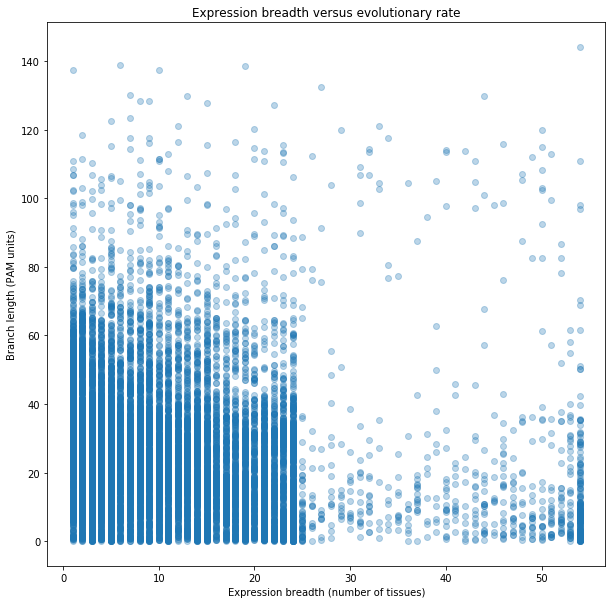

Pearson correlation: -0.178
Tau: -0.171 p_value: 0.000
Spearman: -0.247 p_value: 0.000


In [48]:
expression_breadths = direct_lineage_genes["expression_breadth"].tolist()
branch_lengths = direct_lineage_genes["branch_length"].tolist()

# summarize
print("Number of data points: "+ str(len(expression_breadths)))
print('expr_breadth_delta: mean=%.3f stdv=%.3f' % (mean(expression_breadths), std(expression_breadths)))
print('branch_length_delta: mean=%.3f stdv=%.3f' % (mean(branch_lengths), std(branch_lengths)))

# plot
pyplot.scatter(expression_breadths, branch_lengths, alpha=0.3)
pyplot.xlabel('Expression breadth (number of tissues)')
pyplot.ylabel('Branch length (PAM units)')
pyplot.title('Expression breadth versus evolutionary rate')
pyplot.show()

from scipy.stats import pearsonr, kendalltau
# calculate Pearson's correlation
corr, _ = pearsonr(expression_breadths, branch_lengths)
print('Pearson correlation: %.3f' % corr)

tau, p_value = kendalltau(expression_breadths, branch_lengths)
print("Tau: %.3f p_value: %.3f"% (tau, p_value))

# Spearman
spearman, p_val = spearmanr(expression_breadths, branch_lengths)
print("Spearman: %.3f p_value: %.3f" % (spearman, p_val))

## Outlier removal

Number of data points: 13822
expr_breadth_delta: mean=10.762 stdv=7.526
branch_length_delta: mean=23.328 stdv=15.314


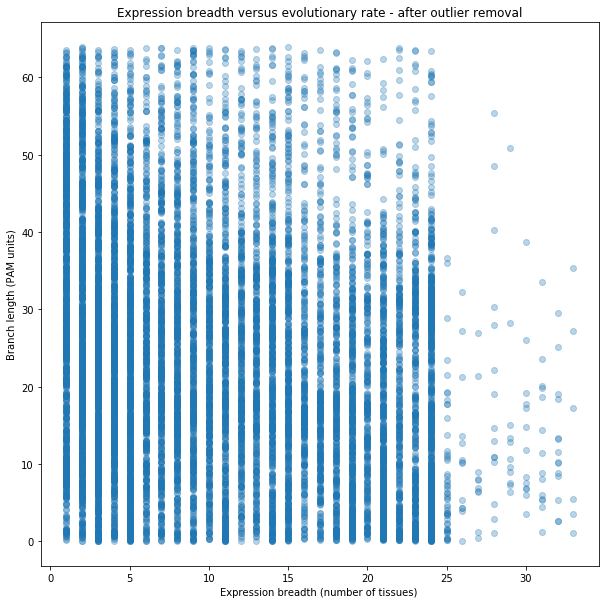

Pearson correlation: -0.233
Tau: -0.162 p_value: 0.000
Spearman: -0.233 p_value: 0.000


In [52]:
mean_eb = mean(expression_breadths)
stddev_eb = std(expression_breadths)

mean_br_len = mean(branch_lengths)
stddev_br_len = std(branch_lengths)


## we keep only data points within 2 stddevs of the mean

data_no_outliers = direct_lineage_genes[
    (direct_lineage_genes["expression_breadth"] < mean_eb + 2 * stddev_eb) &
    (direct_lineage_genes["expression_breadth"] > mean_eb - 2 * stddev_eb) &
    (direct_lineage_genes["branch_length"] < mean_br_len + 2 * stddev_br_len) &
    (direct_lineage_genes["branch_length"] > mean_br_len - 2 * stddev_br_len)
     ]

expression_breadths_no_outliers = data_no_outliers["expression_breadth"].tolist()
branch_lengths_no_outliers = data_no_outliers["branch_length"].tolist()

# summarize
print("Number of data points: "+ str(len(expression_breadths_no_outliers)))
print('expr_breadth_delta: mean=%.3f stdv=%.3f' % (mean(expression_breadths_no_outliers), std(expression_breadths_no_outliers)))
print('branch_length_delta: mean=%.3f stdv=%.3f' % (mean(branch_lengths_no_outliers), std(branch_lengths_no_outliers)))

# plot
pyplot.scatter(expression_breadths_no_outliers, branch_lengths_no_outliers, alpha=0.3)
pyplot.xlabel('Expression breadth (number of tissues) ')
pyplot.ylabel('Branch length (PAM units)')
pyplot.title('Expression breadth versus evolutionary rate - after outlier removal')
pyplot.show()

# calculate Pearson's correlation
corr, _ = pearsonr(expression_breadths_no_outliers, branch_lengths_no_outliers)
print('Pearson correlation: %.3f' % corr)

tau, p_value = kendalltau(expression_breadths_no_outliers, branch_lengths_no_outliers)
print("Tau: %.3f p_value: %.3f"% (tau, p_value))

# Spearman
spearman, p_val = spearmanr(expression_breadths_no_outliers, branch_lengths_no_outliers)
print("Spearman: %.3f p_value: %.3f" % (spearman, p_val))

## Focusing on expression breadth > 25

Number of data points: 699
expr_breadth_delta: mean=45.474 stdv=9.056
branch_length_delta: mean=20.435 stdv=28.098


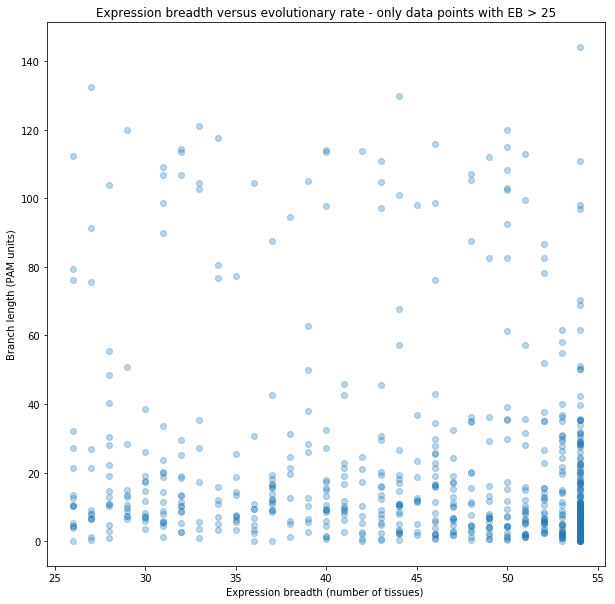

Pearson correlation: -0.167
Tau: -0.166 p_value: 0.000
Spearman: -0.239 p_value: 0.000


In [53]:
filtered_data = direct_lineage_genes[direct_lineage_genes["expression_breadth"] > 25]

expression_breadths_filtered = filtered_data["expression_breadth"].tolist()
branch_lengths_filtered = filtered_data["branch_length"].tolist()

# summarize
print("Number of data points: "+ str(len(expression_breadths_filtered)))
print('expr_breadth_delta: mean=%.3f stdv=%.3f' % (mean(expression_breadths_filtered), std(expression_breadths_filtered)))
print('branch_length_delta: mean=%.3f stdv=%.3f' % (mean(branch_lengths_filtered), std(branch_lengths_filtered)))

# plot
pyplot.scatter(expression_breadths_filtered, branch_lengths_filtered, alpha=0.3)
pyplot.xlabel('Expression breadth (number of tissues) ')
pyplot.ylabel('Branch length (PAM units)')
pyplot.title('Expression breadth versus evolutionary rate - only data points with EB > 25')
pyplot.show()

# calculate Pearson's correlation
corr, _ = pearsonr(expression_breadths_filtered, branch_lengths_filtered)
print('Pearson correlation: %.3f' % corr)

tau, p_value = kendalltau(expression_breadths_filtered, branch_lengths_filtered)
print("Tau: %.3f p_value: %.3f"% (tau, p_value))

# Spearman
spearman, p_val = spearmanr(expression_breadths_filtered, branch_lengths_filtered)
print("Spearman: %.3f p_value: %.3f" % (spearman, p_val))

## Case 2. Expression change versus number of mutations in sequence

Cases 2. and 3. are pairwise analyses of paralogous copies, therefore as a first step we construct all pairs.


In [56]:
from itertools import combinations
pair_data = direct_lineage_genes.groupby('duplication_hog')['gene'].apply(lambda x : list(combinations(x.values,2)))\
            .apply(pd.Series).stack().reset_index(level=0,name='gene_pair')


In [62]:
print(pair_data.head())

                                            duplication_hog  \
0  https://omabrowser.org/oma/hog/information/HOG:0010189.1   
0  https://omabrowser.org/oma/hog/information/HOG:0010191.1   
0  https://omabrowser.org/oma/hog/information/HOG:0010197.1   
1  https://omabrowser.org/oma/hog/information/HOG:0010197.1   
2  https://omabrowser.org/oma/hog/information/HOG:0010197.1   

                                                                                  gene_pair  
0  (https://omabrowser.org/oma/info/ANOCA01007, https://omabrowser.org/oma/info/ANOCA01370)  
0  (https://omabrowser.org/oma/info/ANOCA06746, https://omabrowser.org/oma/info/ANOCA14594)  
0  (https://omabrowser.org/oma/info/CHICK00949, https://omabrowser.org/oma/info/CHICK00951)  
1  (https://omabrowser.org/oma/info/CHICK00949, https://omabrowser.org/oma/info/CHICK00952)  
2  (https://omabrowser.org/oma/info/CHICK00951, https://omabrowser.org/oma/info/CHICK00952)  


In [66]:
pairs_dataframe = pd.concat([pair_data['duplication_hog'],pair_data['gene_pair'].apply(pd.Series)],1).set_axis(['duplication_hog','gene1','gene2'],1,inplace=False)

In [61]:
print(pairs_dataframe.head())

                                            duplication_hog  \
0  https://omabrowser.org/oma/hog/information/HOG:0010189.1   
0  https://omabrowser.org/oma/hog/information/HOG:0010191.1   
0  https://omabrowser.org/oma/hog/information/HOG:0010197.1   
1  https://omabrowser.org/oma/hog/information/HOG:0010197.1   
2  https://omabrowser.org/oma/hog/information/HOG:0010197.1   

                                        gene1  \
0  https://omabrowser.org/oma/info/ANOCA01007   
0  https://omabrowser.org/oma/info/ANOCA06746   
0  https://omabrowser.org/oma/info/CHICK00949   
1  https://omabrowser.org/oma/info/CHICK00949   
2  https://omabrowser.org/oma/info/CHICK00951   

                                        gene2  
0  https://omabrowser.org/oma/info/ANOCA01370  
0  https://omabrowser.org/oma/info/ANOCA14594  
0  https://omabrowser.org/oma/info/CHICK00951  
1  https://omabrowser.org/oma/info/CHICK00952  
2  https://omabrowser.org/oma/info/CHICK00952  


In [90]:
# now we need to add back the tissues for each gene, as well as the branch lengths

branch_lengths = direct_lineage_genes[["gene","branch_length","tissues"]]

pairs_dataframe_joined = pd.merge(pairs_dataframe, branch_lengths, how='left', left_on='gene1', right_on='gene')

pairs_dataframe_joined = pairs_dataframe_joined.drop(columns=["gene"])

pairs_dataframe_joined = pairs_dataframe_joined.rename(columns={"branch_length":"branch_length_gene1"})
pairs_dataframe_joined = pairs_dataframe_joined.rename(columns={"tissues":"tissues_gene1"})

pairs_dataframe_joined2 = pd.merge(pairs_dataframe_joined, branch_lengths, how='left', left_on='gene2', right_on='gene')
pairs_dataframe_joined2 = pairs_dataframe_joined2.drop(columns=["gene"])
pairs_dataframe_joined2 = pairs_dataframe_joined2.rename(columns={"branch_length":"branch_length_gene2"})
pairs_dataframe_joined2 = pairs_dataframe_joined2.rename(columns={"tissues":"tissues_gene2"})

print(pairs_dataframe_joined2.head())


                                            duplication_hog  \
0  https://omabrowser.org/oma/hog/information/HOG:0010189.1   
1  https://omabrowser.org/oma/hog/information/HOG:0010191.1   
2  https://omabrowser.org/oma/hog/information/HOG:0010197.1   
3  https://omabrowser.org/oma/hog/information/HOG:0010197.1   
4  https://omabrowser.org/oma/hog/information/HOG:0010197.1   

                                        gene1  \
0  https://omabrowser.org/oma/info/ANOCA01007   
1  https://omabrowser.org/oma/info/ANOCA06746   
2  https://omabrowser.org/oma/info/CHICK00949   
3  https://omabrowser.org/oma/info/CHICK00949   
4  https://omabrowser.org/oma/info/CHICK00951   

                                        gene2  branch_length_gene1  \
0  https://omabrowser.org/oma/info/ANOCA01370  48.500000             
1  https://omabrowser.org/oma/info/ANOCA14594  49.500000             
2  https://omabrowser.org/oma/info/CHICK00951  7.481589              
3  https://omabrowser.org/oma/info/CHICK00952 

### Now we can analyse the data pairwise


In [93]:
pairwise_paralogous_copies = pairs_dataframe_joined2

# the total amount of expression change per paralogous pair, 
# defined as the hamming distance between the expression profiles
expression_change = [] 
mutations_in_sequnce = []

for index, pair_row in pairwise_paralogous_copies.iterrows():
    #print(pair_row['gene1'], pair_row['gene2'])
    hamming = len(set(pair_row['tissues_gene1']) - set(pair_row['tissues_gene2'])) +\
              len(set(pair_row['tissues_gene2']) - set(pair_row['tissues_gene1']))
    expression_change.append(hamming)
    mutations_in_sequnce.append(pair_row['branch_length_gene1'] + pair_row['branch_length_gene2'])

Number of data points: 230893
expr_breadth_delta: mean=6.098 stdv=4.782
branch_length_delta: mean=50.871 stdv=23.171


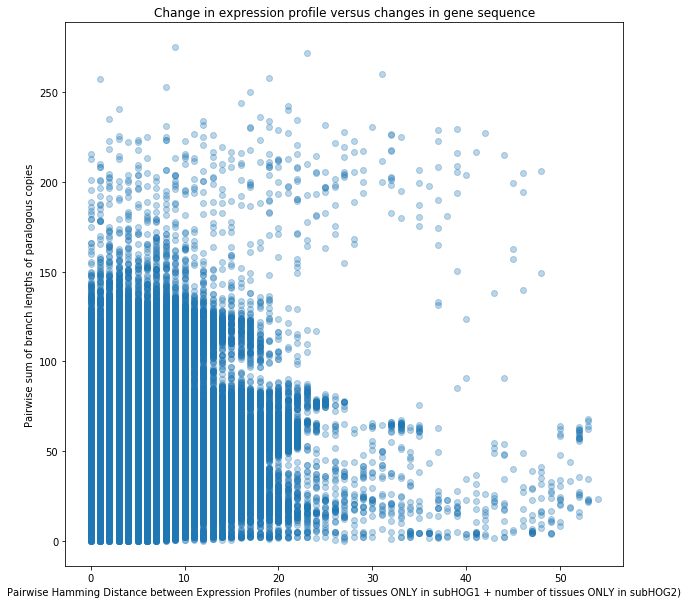

Pearson correlation: -0.140
Tau: -0.181 p_value: 0.000
Spearman: -0.260 p_value: 0.000


In [94]:
# summarize
print("Number of data points: "+ str(len(expression_change)))
print('expr_breadth_delta: mean=%.3f stdv=%.3f' % (mean(expression_change), std(expression_change)))
print('branch_length_delta: mean=%.3f stdv=%.3f' % (mean(mutations_in_sequnce), std(mutations_in_sequnce)))

# plot
pyplot.scatter(expression_change, mutations_in_sequnce, alpha=0.3)
pyplot.xlabel('Pairwise Hamming Distance between Expression Profiles (number of tissues ONLY in subHOG1 + number of tissues ONLY in subHOG2)')
pyplot.ylabel('Pairwise sum of branch lengths of paralogous copies')
pyplot.title('Change in expression profile versus changes in gene sequence')
pyplot.show()

from scipy.stats import pearsonr, kendalltau
# calculate Pearson's correlation
corr, _ = pearsonr(expression_change, mutations_in_sequnce)
print('Pearson correlation: %.3f' % corr)

tau, p_value = kendalltau(expression_change, mutations_in_sequnce)
print("Tau: %.3f p_value: %.3f"% (tau, p_value))

# Spearman
spearman, p_val = spearmanr(expression_change, mutations_in_sequnce)
print("Spearman: %.3f p_value: %.3f" % (spearman, p_val))

## Case 3. Expression change versus branch length difference
### (case where one expression profile is a subset of the second)

In [109]:
# the total amount of expression change per paralogous pair, 
# defined as the hamming distance between the expression profiles
expression_change = [] 
branch_length_delta = []

for index, pair_row in pairwise_paralogous_copies.iterrows():
    subset = None
    superset = None
    
    #print(pair_row['gene1'], pair_row['gene2'])
    if(len(pair_row['tissues_gene1'] - pair_row['tissues_gene2']) > 0 and
              len(pair_row['tissues_gene2'] - pair_row['tissues_gene1']) == 0):
        superset = "gene1"
        subset = "gene2" 

        
    if(len(pair_row['tissues_gene2'] - pair_row['tissues_gene1']) > 0 and
              len(pair_row['tissues_gene1'] - pair_row['tissues_gene2']) == 0):
        superset = "gene2"
        subset = "gene1"
        
    if(subset is not None and superset is not None):
        
        expression_change.append(len(pair_row['tissues_' + superset] - pair_row['tissues_' + subset]))
        
        # we expect the broader expression profile (superset) to be on the smaller branch, closer to the ancestral gene
        # therefore we compute the length of the subset - the length of the superset
        branch_length_delta.append(pair_row['branch_length_' + subset] - pair_row['branch_length_' + superset])

Number of data points: 90200
expr_breadth_delta: mean=6.253 stdv=5.617
branch_length_delta: mean=-0.766 stdv=6.923


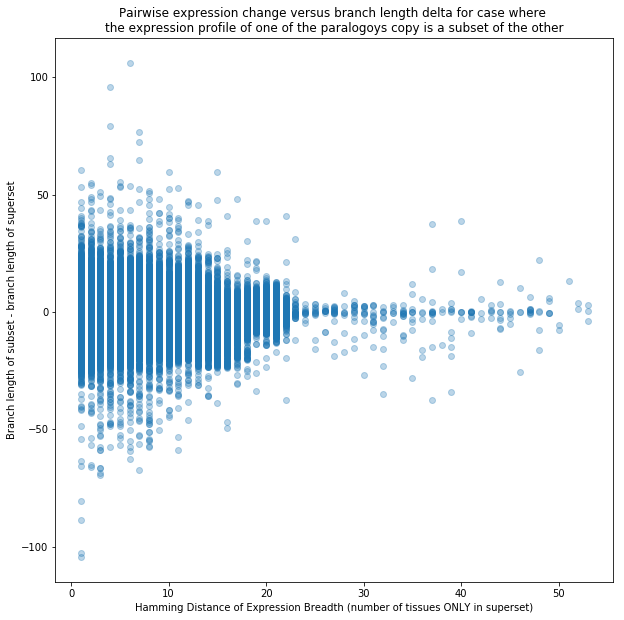

Pearson correlation: -0.020
Tau: -0.024 p_value: 0.000
Spearman: -0.034 p_value: 0.000


In [110]:
# summarize
print("Number of data points: "+ str(len(expression_change)))
print('expr_breadth_delta: mean=%.3f stdv=%.3f' % (mean(expression_change), std(expression_change)))
print('branch_length_delta: mean=%.3f stdv=%.3f' % (mean(branch_length_delta), std(branch_length_delta)))

# plot
pyplot.scatter(expression_change, branch_length_delta, alpha=0.3)
pyplot.xlabel('Hamming Distance of Expression Breadth (number of tissues ONLY in superset)')
pyplot.ylabel('Branch length of subset - branch length of superset')
pyplot.title('Pairwise expression change versus branch length delta for case where \nthe expression profile of one of the paralogoys copy is a subset of the other')
pyplot.show()

from scipy.stats import pearsonr, kendalltau
# calculate Pearson's correlation
corr, _ = pearsonr(expression_change, branch_length_delta)
print('Pearson correlation: %.3f' % corr)

tau, p_value = kendalltau(expression_change, branch_length_delta)
print("Tau: %.3f p_value: %.3f"% (tau, p_value))

# Spearman
spearman, p_val = spearmanr(expression_change, branch_length_delta)
print("Spearman: %.3f p_value: %.3f" % (spearman, p_val))

## Finally, to quantify the pairwise difference in the branch lengths, we conduct a t-test

In [113]:
branch_lengths_subset = [] 
branch_lengths_superset = []

for index, pair_row in pairwise_paralogous_copies.iterrows():
    subset = None
    superset = None
    
    #print(pair_row['gene1'], pair_row['gene2'])
    if(len(pair_row['tissues_gene1'] - pair_row['tissues_gene2']) > 0 and
              len(pair_row['tissues_gene2'] - pair_row['tissues_gene1']) == 0):
        superset = "gene1"
        subset = "gene2" 

        
    if(len(pair_row['tissues_gene2'] - pair_row['tissues_gene1']) > 0 and
              len(pair_row['tissues_gene1'] - pair_row['tissues_gene2']) == 0):
        superset = "gene2"
        subset = "gene1"
        
    if(subset is not None and superset is not None):
        branch_lengths_subset.append(pair_row['branch_length_' + subset])
        branch_lengths_superset.append(pair_row['branch_length_' + superset])
        

In [114]:
# summarize
print("Number of data points: "+ str(len(branch_lengths_superset)))

print('superset: mean=%.3f stdv=%.3f' % (mean(branch_lengths_superset), std(branch_lengths_superset)))
print('subset: mean=%.3f stdv=%.3f' % (mean(branch_lengths_subset), std(branch_lengths_subset)))
print('diffs: mean=%.3f stdv=%.3f' % (mean(branch_lengths_delta), std(branch_lengths_delta)))

print(ttest_rel(branch_lengths_superset, branch_lengths_subset))

print(wilcoxon(branch_lengths_superset, branch_lengths_subset))

Number of data points: 90200
superset: mean=27.682 stdv=10.890
subset: mean=26.916 stdv=10.735


NameError: name 'branch_lengths_delta' is not defined